# General informations

In [13]:
## CHA-AIPH Project
# -*- coding: utf-8 -*-

"""
Created on Tue Jan 18 2021
@author: Tisseaux Antoine

This script is used to predict survival at hospital discharge for ICU patients
ML model used: XGB
"""

'\nCreated on Tue Jan 18 2021\n@author: Tisseaux Antoine\n\nThis script is used to predict survival at hospital discharge for ICU patients\nML model used: XGB\n'

# set environement

Importing packages

In [19]:
# Importing libraries:

import pickle as pkl
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics
import matplotlib.pyplot as plt

Importing files

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



loading csv files

In [21]:
my_df_all_patients = pd.read_csv('/content/drive/MyDrive/CHAIPH_PROJECT_GR2/data/final_dataframes/sepsis_patients/my_df_all_sepsis_scaled.csv', sep=",")

setting options for pandas

In [22]:
# Displaying option: all columns
pd.set_option('display.max_columns', None)

setting a random seed:

In [23]:
# setting random seed
SEED = 25

# Creating train and test datasets:

In [24]:
# creating a vector y with the outcome:
y = my_df_all_patients["hospital_death"]

# creating a dataset X with the variables used for the prediction
X = my_df_all_patients.drop('hospital_death', axis=1)

## splitting the data into train set and test set:

80% for training, 20% for testing : (test_size = 0.2)

we stratify on outcome

In [25]:
# splitting scaled data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

Data augmentation

In [26]:
ros = RandomOverSampler(random_state=SEED)

X_train, y_train = ros.fit_resample(X_train, y_train)

## vizualizing splitting:

train dataset:

In [27]:
# training dataset size:
print("Nb of patients in training set is %i\n" % X_train.shape[0])
proportion_train = y_train.value_counts() / y_train.count()

# displaying number of patients with CKD and without CKD in the training set
print(f"Nb of patients dead at hospital discharge is {y_train.value_counts()[0]} "
      f"representing {proportion_train[0]} % of training dataset")
print(f"Nb of patients alive at hospital discharge is {y_train.value_counts()[1]} "
      f"representing {proportion_train[1]} % of training dataset\n")

Nb of patients in training set is 25160

Nb of patients dead at hospital discharge is 12580 representing 0.5 % of training dataset
Nb of patients alive at hospital discharge is 12580 representing 0.5 % of training dataset



test dataset:

In [28]:
# test dataset size:
print("Nb of patients in test set is %i\n" % X_test.shape[0])
proportion_test = y_test.value_counts() / y_test.count()

# displaying number of patients with CKD and without CKD in the test set
print(f"Nb of patients dead at hospital discharge is {y_test.value_counts()[0]} "
      f"representing {proportion_test[0]} % of test dataset")
print(f"Nb of patients dead at hospital discharge is {y_test.value_counts()[1]} "
      f"representing {proportion_test[1]} % of test dataset\n")

Nb of patients in test set is 3720

Nb of patients dead at hospital discharge is 3146 representing 0.8456989247311828 % of test dataset
Nb of patients dead at hospital discharge is 574 representing 0.1543010752688172 % of test dataset



# Tuning hyperparameters :

## Grid search CrossValidation:



we suquencially find optimal hyperparameters:
- fixing learning rate to 0.1
- finding best number of estimator
- finding best max_depth et min_child_weight
- finding best gamma
- finding best subsample and colsample_bytree
- tuning regularization parameters
- lower learning rate 


possible hyperparameters:

In [88]:
# we will find the best hyperparameters by buildind a cross validation search grid:

# Set all the combinaisons hyperpameters to be tested:
tuned_parameters = {'reg_alpha':[10], 'reg_lambda':[10]}

running grid search:

In [89]:
print("# Tuning hyper-parameters")
print()


# Using GridSearchCV function to explore an estimator for multiple values of hyperameters
# We specify the estimator to use and all the hyperparameters in the variable 'tuned_parameters':
# GridSearchCV will compute a given score for each combinaison of hyperparameters
# We will compute for F1 score
xgb_clf_grid = GridSearchCV(xgb.XGBClassifier(n_estimators = 80,
                                              learning_rate = 0.1,
                                              scale_pos_weight = 1,
                                              min_child_weight = 3,
                                              max_depth = 6,
                                              gamma = 0.4,
                                              colsample_bytree = 0.8, 
                                              subsample = 0.8,
                                              objective = 'binary:logistic',
                                              seed = SEED), tuned_parameters, scoring='f1', n_jobs=-1, cv=5, verbose=3)

# we train the SVM estimators:
xgb_clf_grid.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()

# We print the best combinaison of hyperpameters founded
print(xgb_clf_grid.best_params_)
print()

print("Grid scores on development set:")
print()

# we will display the mean and the standard deviation of F1-score for
# all the combinaisons of hyperparameters tested with grid search:
means = xgb_clf_grid.cv_results_['mean_test_score']
stds = xgb_clf_grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, xgb_clf_grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()

y_true, xgb_y_pred = y_test, xgb_clf_grid.predict(X_test)
print(classification_report(y_true, xgb_y_pred))
print()

# Tuning hyper-parameters

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters set found on development set:

{'reg_alpha': 10, 'reg_lambda': 10}

Grid scores on development set:

0.801 (+/-0.011) for {'reg_alpha': 10, 'reg_lambda': 10}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86      3146
         1.0       0.37      0.66      0.48       574

    accuracy                           0.78      3720
   macro avg       0.65      0.73      0.67      3720
weighted avg       0.84      0.78      0.80      3720




# building the best XGB model:

In [90]:
# We declare the logistic regression estimator:
xgb_clf = xgb_clf_grid

# Performance evaluation:

## Confusion Matrix

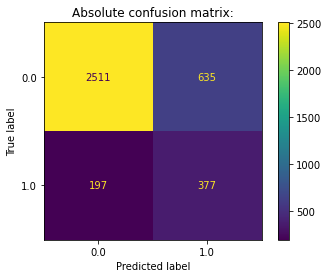

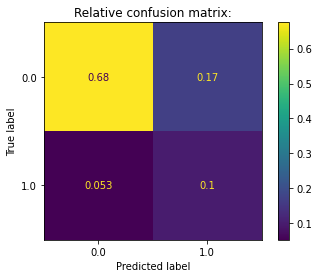

In [91]:
# displaying absolute confusion matrix:
disp = ConfusionMatrixDisplay.from_predictions(y_test, xgb_y_pred, display_labels=xgb_clf.classes_)
plt.title("Absolute confusion matrix:")
plt.show()

# displaying relative confusion matrix:
disp = ConfusionMatrixDisplay.from_predictions(y_test, xgb_y_pred, display_labels=xgb_clf.classes_, normalize='all')
plt.title("Relative confusion matrix:")
plt.show()

## Performance scores

In [92]:
# performance scores
print('accuracy score: %f\n' % accuracy_score(y_test, xgb_y_pred))
F1_log = f1_score(y_test, xgb_y_pred, average='weighted')
print('f1_score: %f\n' % F1_log)
print('recall score: %f\n' % recall_score(y_test, xgb_y_pred, average='weighted'))
print('precision score: %f\n' % precision_score(y_test, xgb_y_pred, average='weighted'))

accuracy score: 0.776344

f1_score: 0.798860

recall score: 0.776344

precision score: 0.841658



## ROC curve

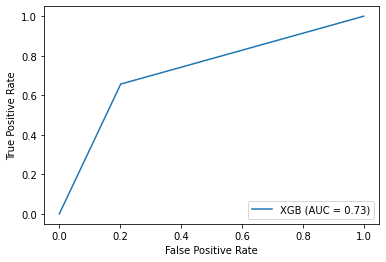


roc_auc score: 0.727475407076294


In [93]:
# displaying ROC curve:
fpr, tpr, thresholds = metrics.roc_curve(y_test, xgb_y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(tpr=tpr, fpr=fpr, roc_auc=roc_auc, estimator_name="XGB")
display.plot()
plt.show()

print('\nroc_auc score:', metrics.roc_auc_score(y_test, xgb_y_pred, average='weighted'))

## Saving model

In [94]:
pkl.dump(xgb_clf, open('/content/drive/MyDrive/CHAIPH_PROJECT_GR2/scripts/models/xgb.pkl', "wb"))